# Nowcast evaluation

In [1]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.realtime_utils import *
from src.load_data import *
from plotnine import *

In [2]:
model_names = {
    'KIT-MeanEnsemble' : 'Ensemble',
    'lightgbm2' : 'LightGBM-Old',
    'lightgbm23' : 'LightGBM',
    'lightgbm_skip': 'LightGBM-Skip',
    'lightgbm_retrain': 'LightGBM-Retrain',
    'tsmixer' : 'TSMixer',
    'KIT-hhh4' : 'hhh4',
    'KIT-hhh4_all_data': 'hhh4_all_data',
    'KIT-hhh4_all_data_skip': 'hhh4_all_data_skip',
    'KIT-baseline' : 'Nowcast',
    'baseline' : 'Baseline'
}

In [3]:
model_colors = {
    "LightGBM": "#B30000",
    "TSMixer": "#E69F00",
    "LightGBM-Retrain": "#999999",
    "Nowcast": "#56B4E9",
    "hhh4_all_data": "#F0E442",
    "Ensemble": "#009E73",
    "LightGBM-Old": "#60D1B3",
    "Baseline": "#80471C",
    "hhh4": "#3C4AAD",
    "hhh4_all_data_skip": "#CC79A7",
    "LightGBM-Skip": "#000000"
}

In [4]:
def load_nowcasts(start='2023-12-14', end='2024-09-19', include_truth=True):
    files = glob.glob(f'../data/nowcasts/KIT-baseline/*.csv') 

    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file[:-4].split('/')[-1].split('-', 5)[-1]
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    df = df[df.forecast_date.between(start, end)].reset_index(drop=True)
    
    if include_truth:
        df = add_truth(df, target=True)
    
    return df

In [5]:
df_nowcasts = load_nowcasts()

In [6]:
df = load_predictions('post-covid')

In [7]:
df.model.unique()

array(['lightgbm2', 'lightgbm_skip', 'lightgbm_retrain', 'lightgbm23',
       'baseline', 'lightgbm', 'tsmixer', 'KIT-hhh4_all_data',
       'KIT-hhh4_all_data_skip', 'KIT-MeanEnsemble', 'KIT-hhh4'],
      dtype=object)

In [8]:
df = df[~df.model.isin(['lightgbm', 'lightgbm2'])]

In [9]:
df = pd.concat([df, df_nowcasts], ignore_index=True)

In [10]:
df.model = df.model.replace(model_names)

In [11]:
df = df[df.forecast_date != '2023-12-28']

In [12]:
df = df[df.target_end_date.between('2023-01-04', '2024-09-15')].reset_index(drop=True)

In [13]:
df.target_end_date.max()

'2024-09-15'

# Compute scores

#### National level

In [14]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,127.188894,160.733013,63.442468,351.364375,0.443750,0.956250
1,Ensemble,379.725849,188.535785,493.019263,1061.280897,0.333333,0.953333
2,LightGBM-Retrain,390.738522,60.592784,683.954748,1135.286054,0.586667,0.926667
3,LightGBM,383.276218,45.634760,723.740799,1152.651777,0.506667,0.933333
4,TSMixer,429.783552,316.963840,414.635035,1161.382427,0.373333,0.900000
5,LightGBM-Skip,345.496429,47.644957,844.171537,1237.312923,0.406667,0.893333
6,hhh4_all_data_skip,443.280612,379.345918,589.292857,1411.919388,0.221429,0.835714
7,hhh4,353.552381,474.912381,616.855238,1445.320000,0.260000,0.726667
8,hhh4_all_data,471.014031,571.164541,482.704082,1524.882653,0.294643,0.839286
9,Baseline,454.529829,13.400402,1632.324950,2100.255181,0.197183,0.485915


In [15]:
# evaluate_models(df, 'national', by_horizon=True)

#### Age groups

In [15]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,Nowcast,19.616128,35.095433,21.669525,76.381086,0.378125,0.814583
1,Ensemble,85.778754,50.509864,78.140914,214.429533,0.433333,0.927778
2,LightGBM-Retrain,68.138533,36.680470,126.000808,230.819810,0.341111,0.818889
3,LightGBM,67.579219,32.582348,140.133366,240.294934,0.316667,0.788889
4,LightGBM-Skip,60.691095,31.644871,155.942519,248.278485,0.275556,0.751111
5,hhh4,105.287302,92.259524,58.003492,255.550317,0.495556,0.927778
6,TSMixer,90.202557,66.080113,115.522073,271.804742,0.362222,0.764444
7,hhh4_all_data,128.135629,89.792730,66.441114,284.369473,0.513393,0.947917
8,hhh4_all_data_skip,126.572279,88.290136,73.121599,287.984014,0.514286,0.938095
9,Baseline,97.020523,7.764923,239.297284,344.082730,0.272300,0.625587


In [17]:
# evaluate_models(df, 'age', by_horizon=True)

In [18]:
# evaluate_models(df, 'age', by_age=True)

# Plots

## By horizon

In [16]:
df_national = evaluate_models(df, 'national', by_horizon=True)
df_age = evaluate_models(df, 'age', by_horizon=True)

df_wide = pd.concat([
    df_national.assign(level='national'),
    df_age.assign(level='age')],
    ignore_index=True)

df_long = pd.melt(df_wide, id_vars=['level', 'horizon', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

df_long['level'] = pd.Categorical(df_long['level'], categories=['national', 'age'], ordered=True)

In [17]:
model_colors.keys()

dict_keys(['LightGBM', 'TSMixer', 'LightGBM-Retrain', 'Nowcast', 'hhh4_all_data', 'Ensemble', 'LightGBM-Old', 'Baseline', 'hhh4', 'hhh4_all_data_skip', 'LightGBM-Skip'])

In [18]:
def plot_scores_by_horizon_and_model(df, level='national'):
    scores = df[df.level==level].copy()
    
    desired_order = ['Nowcast', 'Ensemble', 'LightGBM-Retrain', 'LightGBM', 'LightGBM-Skip', 'TSMixer', 'hhh4', 'hhh4_all_data', 'hhh4_all_data_skip', 'Baseline']
    scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS:", title="WIS by horizon")
        + facet_grid(cols='horizon', scales="free", space='free')  # Create a facet for each horizon
        #+ facet_wrap('~horizon', nrow=1, scales='free_x', space='free')  # Create a facet for each horizon
        + theme_bw()
        + theme(legend_position='bottom',
            legend_title_position='left',
            strip_text=element_text(size=9),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=11)            # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


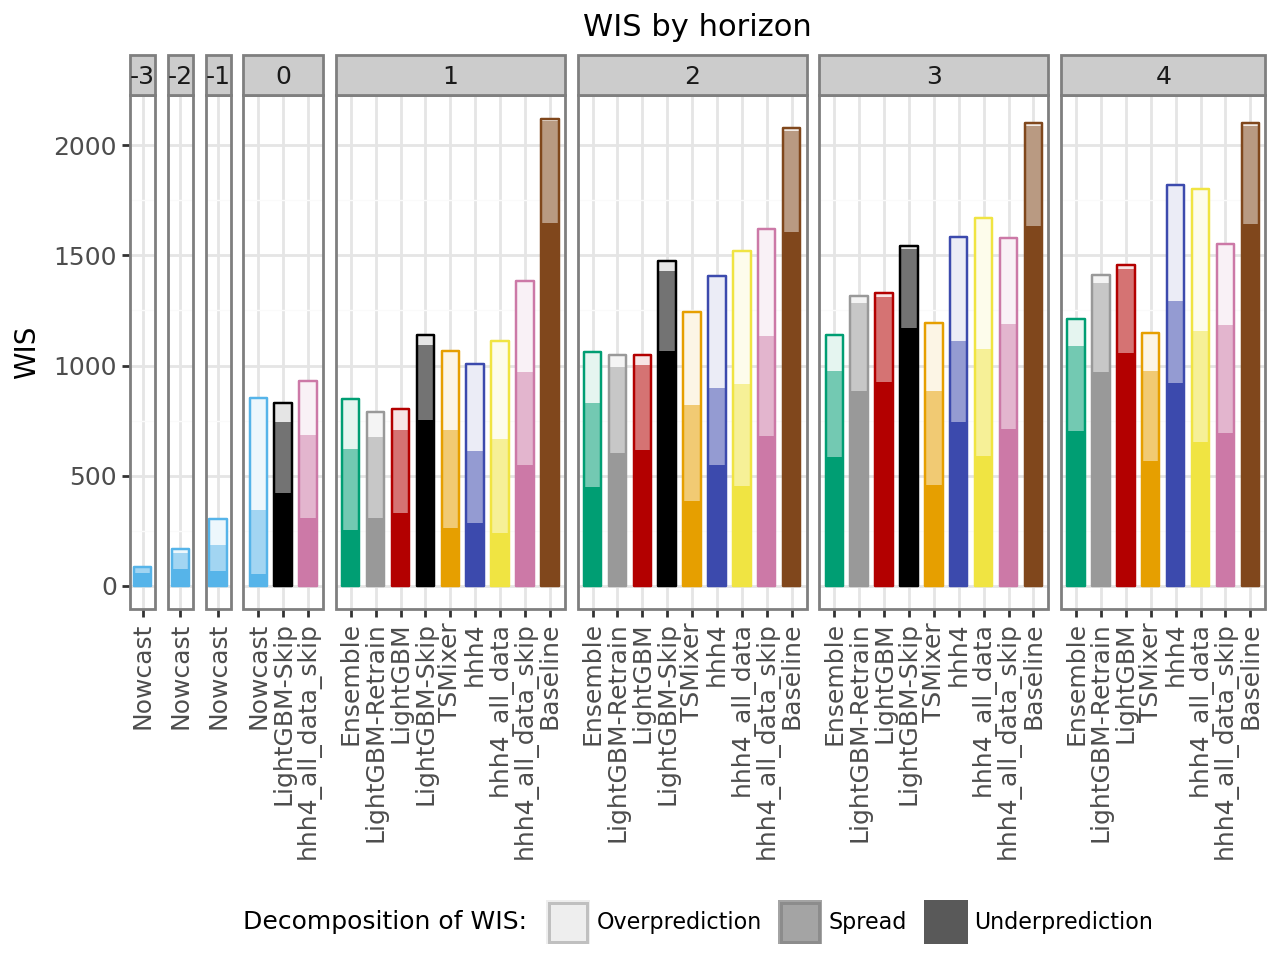

In [19]:
p = plot_scores_by_horizon_and_model(df_long, 'national')
p 

In [20]:
p.save("../figures/wis_with_nowcast.pdf", width = 165, height = 120, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 165.0 x 120.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_with_nowcast.pdf


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


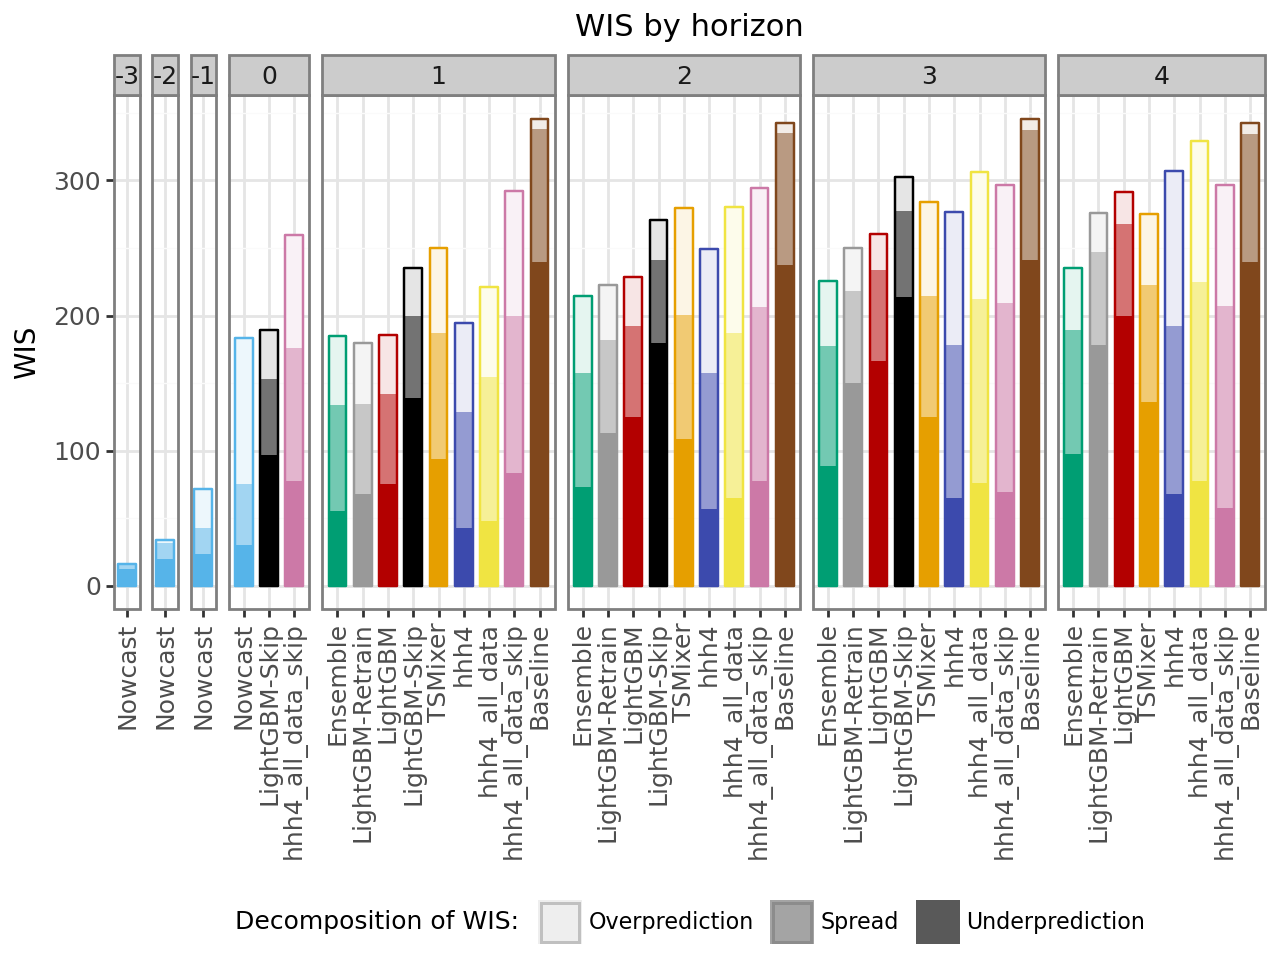

In [21]:
p = plot_scores_by_horizon_and_model(df_long, 'age')
p 

In [22]:
p.save("../figures/wis_with_nowcast_age.pdf", width = 165, height = 120, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 165.0 x 120.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_with_nowcast_age.pdf


In [ ]:
p = plot_scores_by_horizon_and_model(df_long, level='age')
p

In [141]:
p.save("../figures/wis_age_horizon.pdf", width = 160, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age_horizon.pdf


## By age group

In [75]:
df.model.unique()

array(['LightGBM-Skip', 'LightGBM-Retrain', 'LightGBM', 'Baseline',
       'TSMixer', 'hhh4_all_data', 'hhh4_all_data_skip', 'Ensemble',
       'hhh4', 'Nowcast'], dtype=object)

In [84]:
scores_age = evaluate_models(df[df.model != 'Nowcast'], 'age', by_age=True)

In [85]:
scores_age = pd.melt(scores_age, id_vars=['age_group', 'model'], value_vars=['wis', 'underprediction', 'spread', 'overprediction'], 
                 var_name='metric', value_name='value')

In [86]:
scores_age

,age_group,model,metric,value
0,00-04,Ensemble,wis,212.158571
1,00-04,Baseline,wis,224.854728
2,00-04,LightGBM-Skip,wis,234.619905
3,00-04,LightGBM,wis,239.834695
4,00-04,TSMixer,wis,243.407537
...,...,...,...,...
211,80+,TSMixer,overprediction,106.508170
212,80+,hhh4,overprediction,148.067619
213,80+,hhh4_all_data,overprediction,155.017857
214,80+,Baseline,overprediction,23.458753


In [87]:
model_colors.keys()

dict_keys(['LightGBM', 'TSMixer', 'LightGBM-Retrain', 'Nowcast', 'hhh4_all_data', 'Ensemble', 'LightGBM-Old', 'Baseline', 'hhh4', 'hhh4_all_data_skip', 'LightGBM-Skip'])

In [88]:
def plot_scores_by_age_group(scores):
    desired_order = ['Ensemble', 'LightGBM', 'LightGBM-Retrain', 'LightGBM-Old', 'LightGBM-Skip', 'TSMixer', 'hhh4', 'hhh4_all_data', 'hhh4_all_data_skip', 'Baseline']
    scores['model'] = pd.Categorical(scores['model'], categories=desired_order, ordered=True) 
    
    plot = (
        ggplot() 
        + geom_bar(scores[scores.metric == 'wis'], aes(x='model', y='value', color='model'), fill='white', stat='identity', width=0.7,
                   show_legend=False)
        + geom_bar(scores[scores.metric != 'wis'], aes(x='model', y='value', fill='model', alpha='metric'), size=0.1, stat='identity', width=0.7, 
                   show_legend={'color': False,
                                'fill': False,
                                'alpha': True})
        + scale_color_manual(values=model_colors)
        + scale_fill_manual(values=model_colors)
        + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=False))
        + labs(x="", y="WIS", color="Model", alpha="Decomposition\nof WIS:", title="")
        + facet_wrap('~age_group')
        + theme_bw()
        + theme(legend_position='right',
            legend_title_position='top',
            strip_text=element_text(size=10),             # Facet title text size
            legend_title=element_text(size=9),           # Legend title text size
            legend_text=element_text(size=8),             # Legend item text size
            axis_text_x=element_text(size=9, rotation=90, ha="center"),               # Axis text (tick labels) size
            axis_text_y=element_text(size=9),
            axis_title=element_text(size=10),             # Axis title text size
            plot_title=element_text(size=14)              # Plot title text size)
       )
        #+ coord_flip()
    )
    
    return plot

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


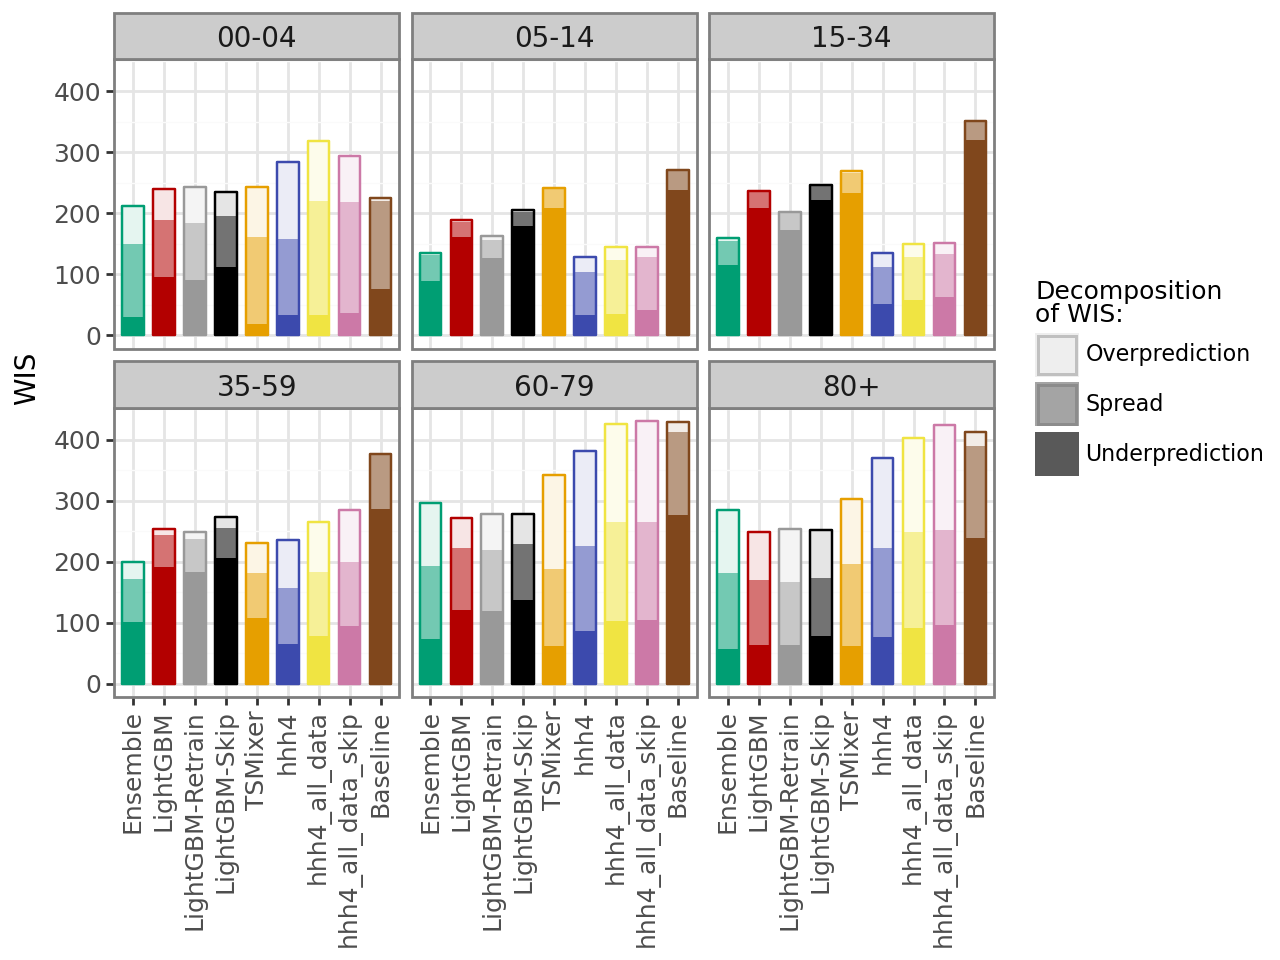

In [89]:
p = plot_scores_by_age_group(scores_age)
p

In [163]:
p.save("../figures/wis_age.pdf", width = 160, height = 110, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 110.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/wis_age.pdf
